In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import sklearn
import optuna

/Users/mikeking/Desktop/Crypto-Return-Prediction/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def clean(ticker):
    ydf = yf.download(ticker, interval="1d")
    #ydf.to_csv(f'y{ticker}.csv')
    ydf.to_csv(f'test.csv')

    # btc = pd.read_csv(f'y{ticker}.csv')
    btc = pd.read_csv(f'test.csv')
    btc = btc.drop([0,1])
    btc['Date'] = pd.to_datetime(btc['Price']).dt.date
    # btc['Date'] = pd.to_datetime(btc['Price']).dt.floor('T')
    btc= btc.set_index('Date')
    btc = btc.drop(['Price'], axis = 1)
    btc = btc.reset_index()
    #btc['Ticker'] = ticker
    return btc

In [3]:
btc = clean('BTC-USD')
btc[btc.columns[1:]] = btc[btc.columns[1:]].astype(float)

btc

[*********************100%***********************]  1 of 1 completed


,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-17,457.334015,457.334015,468.174011,452.421997,465.864014,2.105680e+07
1,2014-09-18,424.440002,424.440002,456.859985,413.104004,456.859985,3.448320e+07
2,2014-09-19,394.795990,394.795990,427.834991,384.532013,424.102997,3.791970e+07
3,2014-09-20,408.903992,408.903992,423.295990,389.882996,394.673004,3.686360e+07
4,2014-09-21,398.821014,398.821014,412.425995,393.181000,408.084991,2.658010e+07
...,...,...,...,...,...,...,...
3712,2024-11-15,91066.007812,91066.007812,91868.742188,87124.898438,87284.179688,7.824311e+10
3713,2024-11-16,90558.476562,90558.476562,91763.945312,90094.226562,91064.367188,4.433319e+10
3714,2024-11-17,89845.851562,89845.851562,91433.039062,88741.664062,90558.460938,4.635016e+10
3715,2024-11-18,90542.640625,90542.640625,92596.789062,89393.593750,89843.718750,7.553578e+10


In [4]:

btc['ret'] = btc['Adj Close'].pct_change()
btc['logret'] = np.log1p(btc['ret'])
btc['Gain'] = btc['logret'].apply(lambda x: x if x > 0 else 0)
btc['Loss'] = btc['logret'].apply(lambda x: -x if x < 0 else 0)

windows = [7, 15, 30, 60, 120, 180]

for i in windows:
    #rolling volatilities
    btc[f'vol_{i}'] = btc['logret'].rolling(window=i).std()

    #relative strength index
    btc[f'RSI_{i}'] = 100 - (100 / (1 + (btc['Gain'].rolling(window=i).mean() / btc['Loss'].rolling(window=i).mean())))

    # momentum score
    btc[f'mom_{i}'] = (1/i) * btc['logret'].rolling(i,i).sum().reset_index(drop=True)

    #exponential moving average
    btc[f'ewma_{i}'] = btc['logret'].ewm(span=i, min_periods=i).mean()

btc = btc.dropna().reset_index(drop=True)
btc['target'] = (btc['logret'].shift(-1) > 0).astype(int)
btc


,Date,Adj Close,Close,High,Low,Open,Volume,ret,logret,Gain,...,ewma_60,vol_120,RSI_120,mom_120,ewma_120,vol_180,RSI_180,mom_180,ewma_180,target
0,2015-03-16,290.592987,290.592987,294.112000,285.684998,285.684998,2.151610e+07,0.014665,0.014559,0.014559,...,0.003347,0.046246,46.023427,-0.002406,0.000585,0.043956,45.790611,-0.002519,-0.000496,0
1,2015-03-17,285.505005,285.505005,292.364990,284.373993,290.595001,2.149720e+07,-0.017509,-0.017664,0.000000,...,0.002656,0.046267,45.815970,-0.002543,0.000268,0.043637,46.280156,-0.002203,-0.000715,0
2,2015-03-18,256.299011,256.299011,285.335999,249.869995,285.066986,5.700800e+07,-0.102296,-0.107915,0.000000,...,-0.000978,0.047183,44.882128,-0.003176,-0.001610,0.044035,45.973818,-0.002400,-0.002080,1
3,2015-03-19,260.928009,260.928009,264.243988,248.636002,255.880005,5.273200e+07,0.018061,0.017900,0.017900,...,-0.000357,0.047196,44.937185,-0.003145,-0.001272,0.043972,45.799945,-0.002496,-0.001826,1
4,2015-03-20,261.748993,261.748993,264.847992,259.161987,260.955994,1.845670e+07,0.003146,0.003141,0.003141,...,-0.000242,0.046891,45.738199,-0.002606,-0.001195,0.043941,46.046612,-0.002340,-0.001763,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3532,2024-11-15,91066.007812,91066.007812,91868.742188,87124.898438,87284.179688,7.824311e+10,0.043731,0.042802,0.042802,...,0.008959,0.028371,57.206326,0.002943,0.005363,0.026532,54.628674,0.001765,0.003985,0
3533,2024-11-16,90558.476562,90558.476562,91763.945312,90094.226562,91064.367188,4.433319e+10,-0.005573,-0.005589,0.000000,...,0.008482,0.028154,56.331362,0.002547,0.005182,0.025961,53.524429,0.001317,0.003879,0
3534,2024-11-17,89845.851562,89845.851562,91433.039062,88741.664062,90558.460938,4.635016e+10,-0.007869,-0.007900,0.000000,...,0.007945,0.028167,56.024552,0.002425,0.004966,0.025928,53.694146,0.001376,0.003749,1
3535,2024-11-18,90542.640625,90542.640625,92596.789062,89393.593750,89843.718750,7.553578e+10,0.007755,0.007725,0.007725,...,0.007938,0.028149,55.898173,0.002367,0.005011,0.025905,54.034894,0.001500,0.003793,1


In [5]:
X = btc[btc.columns[11:-1]]
y = btc['target']

In [6]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

# Evaluate Models
print("Random Forest Accuracy:")
print(accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

print("\nXGBoost Accuracy:")
print(accuracy_score(y_test, xgb_predictions))
print(classification_report(y_test, xgb_predictions))


Random Forest Accuracy:
0.5254237288135594
              precision    recall  f1-score   support

           0       0.52      0.44      0.48       350
           1       0.53      0.61      0.56       358

    accuracy                           0.53       708
   macro avg       0.53      0.52      0.52       708
weighted avg       0.53      0.53      0.52       708


XGBoost Accuracy:
0.5084745762711864
              precision    recall  f1-score   support

           0       0.50      0.41      0.45       350
           1       0.51      0.60      0.55       358

    accuracy                           0.51       708
   macro avg       0.51      0.51      0.50       708
weighted avg       0.51      0.51      0.50       708



In [7]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("Random Forest Results:")
print(f"Mean Squared Error: {rf_mse}")
print(f"R-squared Score: {rf_r2}")


Random Forest Results:
Mean Squared Error: 0.25605875706214687
R-squared Score: -0.024365816440542476


In [8]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print("\nXGBoost Results:")
print(f"Mean Squared Error: {xgb_mse}")
print(f"R-squared Score: {xgb_r2}")



XGBoost Results:
Mean Squared Error: 0.3003048577783077
R-squared Score: -0.20137262344360352


In [13]:
# Grid search for best R2 score
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 10, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "tree_method": trial.suggest_categorical("tree_method", ["auto", "exact", "approx", "hist"]),
    }

    model = xgb.XGBRegressor(**param, random_state=42)
    model.fit(X_train, y_train)

    score = sklearn.model_selection.cross_val_score(model, X_test, y_test, n_jobs=-1, cv=3, scoring='r2')
    r2_score = score.mean()
    return r2_score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)
print(study.best_trial)

[I 2024-11-19 17:45:04,474] A new study created in memory with name: no-name-476e6e75-0eee-4e68-a208-2828944e5b89
[I 2024-11-19 17:45:06,344] Trial 0 finished with value: -0.3805345296859741 and parameters: {'n_estimators': 263, 'learning_rate': 0.12080747039531398, 'max_depth': 9, 'min_child_weight': 7.663017797335589, 'subsample': 0.83617819124622, 'colsample_bytree': 0.712033444012505, 'gamma': 0.00031288790846983373, 'reg_alpha': 2.3957074116963565e-08, 'reg_lambda': 0.003940901781778988, 'tree_method': 'auto'}. Best is trial 0 with value: -0.3805345296859741.
[I 2024-11-19 17:45:07,183] Trial 1 finished with value: -0.0267066756884257 and parameters: {'n_estimators': 784, 'learning_rate': 0.018952393602496967, 'max_depth': 2, 'min_child_weight': 3.136381750272561, 'subsample': 0.747229225331226, 'colsample_bytree': 0.9536781531502081, 'gamma': 1.9482502456218975, 'reg_alpha': 2.2376136995191867e-05, 'reg_lambda': 2.434894364151779e-08, 'tree_method': 'hist'}. Best is trial 1 with 

FrozenTrial(number=795, state=TrialState.COMPLETE, values=[-0.002287149429321289], datetime_start=datetime.datetime(2024, 11, 19, 17, 52, 54, 901567), datetime_complete=datetime.datetime(2024, 11, 19, 17, 52, 55, 437598), params={'n_estimators': 654, 'learning_rate': 0.41560631208519555, 'max_depth': 3, 'min_child_weight': 1.9666756465978457, 'subsample': 0.5485395239289113, 'colsample_bytree': 0.6885282611378943, 'gamma': 3.7589062962478, 'reg_alpha': 0.004849800478451076, 'reg_lambda': 1.582777002019766e-05, 'tree_method': 'auto'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'min_child_weight': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': Fl

In [14]:
# Grid search for best MSE
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 10, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "tree_method": trial.suggest_categorical("tree_method", ["auto", "exact", "approx", "hist"]),
    }

    model = xgb.XGBRegressor(**param, random_state=42)
    model.fit(X_train, y_train)

    score = sklearn.model_selection.cross_val_score(model, X_test, y_test, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')
    mse = score.mean()
    return mse

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)
print(study.best_trial)

[I 2024-11-19 17:55:08,638] A new study created in memory with name: no-name-97090405-47df-4a31-be0d-4d8cf5893593
[I 2024-11-19 17:55:09,250] Trial 0 finished with value: -0.25212533147270466 and parameters: {'n_estimators': 891, 'learning_rate': 0.10647278556484474, 'max_depth': 4, 'min_child_weight': 1.047886140747115, 'subsample': 0.5738384342454288, 'colsample_bytree': 0.5224053467064844, 'gamma': 2.865122275784078, 'reg_alpha': 2.2263247660162576e-06, 'reg_lambda': 0.01780609433370925, 'tree_method': 'auto'}. Best is trial 0 with value: -0.25212533147270466.
[I 2024-11-19 17:55:09,503] Trial 1 finished with value: -0.27757058999630285 and parameters: {'n_estimators': 118, 'learning_rate': 0.09678141100993136, 'max_depth': 5, 'min_child_weight': 7.034126631712401, 'subsample': 0.5406040764184709, 'colsample_bytree': 0.8139539435960005, 'gamma': 1.1619081561270679, 'reg_alpha': 0.0023269227025144628, 'reg_lambda': 7.731462075147436e-08, 'tree_method': 'hist'}. Best is trial 0 with v

FrozenTrial(number=757, state=TrialState.COMPLETE, values=[-0.24997521231989928], datetime_start=datetime.datetime(2024, 11, 19, 18, 6, 57, 877057), datetime_complete=datetime.datetime(2024, 11, 19, 18, 6, 58, 762181), params={'n_estimators': 905, 'learning_rate': 0.5690905084189695, 'max_depth': 2, 'min_child_weight': 1.925022951585389, 'subsample': 0.7027423437070898, 'colsample_bytree': 0.7128179776032951, 'gamma': 6.944872367285347, 'reg_alpha': 0.18383908297791254, 'reg_lambda': 0.0035713122604259274, 'tree_method': 'hist'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'min_child_weight': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatD

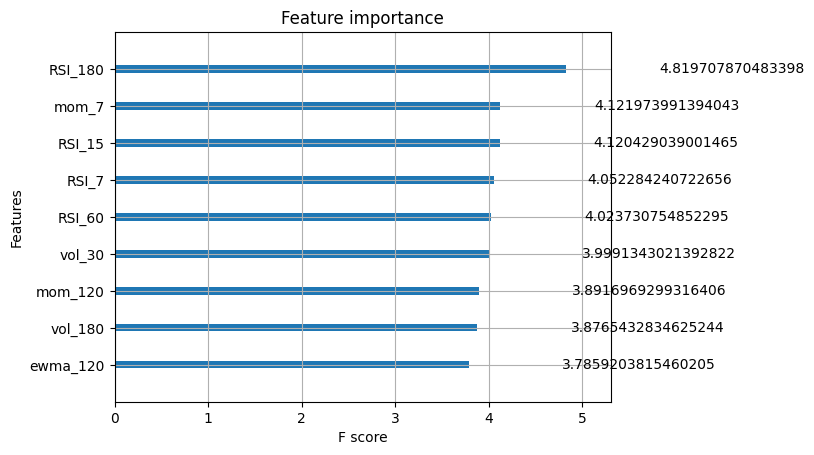

In [18]:
params_r2 = {'n_estimators': 654, 
          'learning_rate': 0.41560631208519555, 
          'max_depth': 3, 
          'min_child_weight': 1.9666756465978457, 
          'subsample': 0.5485395239289113, 
          'colsample_bytree': 0.6885282611378943, 
          'gamma': 3.7589062962478, 
          'reg_alpha': 0.004849800478451076, 
          'reg_lambda': 1.582777002019766e-05, 
          'tree_method': 'auto'}

model = xgb.XGBRegressor(**params_r2, random_state=42)
model.fit(X_train, y_train)
#importance = model.get_booster().get_score(importance_type='gain')
xgb.plot_importance(model.get_booster(), importance_type='gain')
plt.show()

In [ ]:
params_mse={'n_estimators': 905,
            'learning_rate': 0.5690905084189695, 
            'max_depth': 2, 
            'min_child_weight': 1.925022951585389, 
            'subsample': 0.7027423437070898, 
            'colsample_bytree': 0.7128179776032951, 
            'gamma': 6.944872367285347, 
            'reg_alpha': 0.18383908297791254, 
            'reg_lambda': 0.0035713122604259274, 
            'tree_method': 'hist'}

model = xgb.XGBRegressor(**params_mse, random_state=42)
model.fit(X_train, y_train)
importance = model.get_booster().get_score(importance_type='gain')
# xgb.plot_importance(model.get_booster(), importance_type='cover')
# plt.show()
print(importance)
# for some reason this doesnt work. dont know why haha

{'RSI_15': 8.212663650512695}
